# K-Means & Hierarchical Clustering

#### Data Sources: https://github.com/owid/covid-19-data/tree/master/public/data
####               https://en.wikipedia.org/wiki/World_Happiness_Report

**Amacimiz ulkeleri clusterlara ayirmak: Gelismis, Az gelismis, Geri kalmis vs gibi**

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from pyclustertend import hopkins
from sklearn.preprocessing import scale
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_samples,silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

In [2]:
cnt = pd.read_csv ("countries.csv")
cnt.sample(10)

location  population  population_density  median_age  \
151         Singapore     5850343            7915.731        42.4   
130  Papua New Guinea     8947027              18.220        22.6   
58            Finland     5540718              18.136        42.8   
169          Thailand    69799978             135.132        40.1   
143             Samoa      198410              69.413        22.0   
22           Botswana     2351625               4.044        25.8   
6           Argentina    45195777              16.177        31.9   
40      Cote d'Ivoire    26378275              76.399        18.7   
66            Grenada      112519             317.132        29.4   
64              Ghana    31072945             126.719        21.1   

     aged_65_older  aged_70_older  gdp_per_capita  extreme_poverty  \
151         12.922          7.049       85535.383              NaN   
130          3.808          2.142        3823.194              NaN   
58          21.228         13.264       40585.721              NaN   
169         11.373          6.890       16277.671              0.1   
143          5.606          3.564        6021.557              NaN   
22           3.941          2.242       15807.374              NaN   
6           11.198          7.441       18933.907              0.6   
40           2.933          1.582        3601.006             28.2   
66           7.304          5.021       13593.877              NaN   
64           3.385          1.948        4227.630             12.0   

     life_expectancy  human_development_index  
151            83.62                    0.932  
130            64.50                    0.544  
58             81.91                    0.920  
169            77.15                    0.755  
143            73.32                    0.713  
22             69.59                    0.717  
6              76.67                    0.825  
40             57.78                    0.492  
66             72.40                    0.772  
64             64.07                    0.592

In [3]:
cnt.columns

Index(['location', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'life_expectancy', 'human_development_index'],
      dtype='object')

In [4]:
happy_scores = pd.read_csv('happiness_scores.csv')
happy_scores.head()

location  happiness_score
0      Finland            7.809
1      Denmark            7.646
2  Switzerland            7.560
3      Iceland            7.504
4       Norway            7.488

In [5]:
df = pd.merge(cnt, happy_scores, on = "location", how = "left")
df.head()

location  population  population_density  median_age  aged_65_older  \
0  Afghanistan    38928341              54.422        18.6          2.581   
1      Albania     2877800             104.871        38.0         13.188   
2      Algeria    43851043              17.348        29.1          6.211   
3      Andorra       77265             163.755         NaN            NaN   
4       Angola    32866268              23.890        16.8          2.405   

   aged_70_older  gdp_per_capita  extreme_poverty  life_expectancy  \
0          1.337        1803.987              NaN            64.83   
1          8.643       11803.431              1.1            78.57   
2          3.857       13913.839              0.5            76.88   
3            NaN             NaN              NaN            83.73   
4          1.362        5819.495              NaN            61.15   

   human_development_index  happiness_score  
0                    0.498            2.567  
1                    0.785            4.883  
2                    0.754            5.005  
3                    0.858              NaN  
4                    0.581              NaN

# EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 0 to 189
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   location                 190 non-null    object 
 1   population               190 non-null    int64  
 2   population_density       186 non-null    float64
 3   median_age               181 non-null    float64
 4   aged_65_older            179 non-null    float64
 5   aged_70_older            180 non-null    float64
 6   gdp_per_capita           182 non-null    float64
 7   extreme_poverty          124 non-null    float64
 8   life_expectancy          189 non-null    float64
 9   human_development_index  183 non-null    float64
 10  happiness_score          149 non-null    float64
dtypes: float64(9), int64(1), object(1)
memory usage: 17.8+ KB


In [7]:
def null_values(df):
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

null_values(df)

Missing_Records  Percentage (%)
extreme_poverty                       66       34.736842
happiness_score                       41       21.578947
aged_65_older                         11        5.789474
aged_70_older                         10        5.263158
median_age                             9        4.736842
gdp_per_capita                         8        4.210526
human_development_index                7        3.684211
population_density                     4        2.105263
life_expectancy                        1        0.526316

In [8]:
df.describe()

population  population_density  median_age  aged_65_older  \
count  1.900000e+02          186.000000  181.000000     179.000000   
mean   8.183077e+07          341.658210   30.204972       8.590022   
std    5.819950e+08         1612.572496    9.171031       6.198639   
min    8.090000e+02            1.980000   15.100000       1.144000   
25%    2.367885e+06           35.972500   21.700000       3.421500   
50%    9.493482e+06           82.464000   29.400000       6.211000   
75%    3.076120e+07          208.157000   38.700000      14.053000   
max    7.794799e+09        19347.500000   48.200000      27.049000   

       aged_70_older  gdp_per_capita  extreme_poverty  life_expectancy  \
count     180.000000      182.000000       124.000000       189.000000   
mean        5.436161    18439.706637        13.916129        72.862011   
std         4.225454    19589.091950        20.311975         7.584835   
min         0.526000      661.240000         0.100000        53.280000   
25%         2.033500     3924.303000         0.600000        67.270000   
50%         3.541500    11822.138500         2.350000        74.250000   
75%         8.651750    26069.050500        21.675000        77.970000   
max        18.493000   116935.600000        77.600000        86.750000   

       human_development_index  happiness_score  
count               183.000000       149.000000  
mean                  0.708869         5.472221  
std                   0.154410         1.125246  
min                   0.354000         2.567000  
25%                   0.588500         4.677000  
50%                   0.736000         5.515000  
75%                   0.823000         6.258000  
max                   0.953000         7.809000

> * [min-population], [max-population], [max-population_density],[min-gdp_per_capita],[max-extreme_poverty] have anomaly

In [9]:
df[(df["population"] < 1000) | (df["population"] > 1000000000) | (df["population_density"] > 15000)]

location  population  population_density  median_age  aged_65_older  \
35     China  1439323774             147.674        38.7         10.641   
76     India  1380004385             450.419        28.2          5.989   
111   Monaco       39244           19347.500         NaN            NaN   
183  Vatican         809                 NaN         NaN            NaN   
186    World  7794798729              58.045        30.9          8.696   

     aged_70_older  gdp_per_capita  extreme_poverty  life_expectancy  \
35           5.929       15308.712              0.7            76.91   
76           3.414        6426.674             21.2            69.66   
111            NaN             NaN              NaN            86.75   
183            NaN             NaN              NaN            75.12   
186          5.355       15469.207             10.0            72.58   

     human_development_index  happiness_score  
35                     0.752            5.124  
76                     0.640            3.573  
111                      NaN              NaN  
183                      NaN              NaN  
186                      NaN              NaN

In [10]:
df[(df["gdp_per_capita"] < 1000) | (df["extreme_poverty"] > 70)]

location  population  population_density  median_age  \
27                        Burundi    11890781             423.062        17.5   
32       Central African Republic     4829764               7.479        18.3   
44   Democratic Republic of Congo    89561404              35.879        17.0   
95                        Liberia     5057677              49.127        19.2   
100                    Madagascar    27691019              43.951        19.6   
101                        Malawi    19129955             197.519        18.1   
122                         Niger    24206636              16.955        15.1   

     aged_65_older  aged_70_older  gdp_per_capita  extreme_poverty  \
27           2.562          1.504         702.225             71.7   
32           3.655          2.251         661.240              NaN   
44           3.020          1.745         808.133             77.1   
95           3.057          1.756         752.788             38.6   
100          2.929          1.686        1416.440             77.6   
101          2.979          1.783        1095.042             71.4   
122          2.553          1.378         926.000             44.5   

     life_expectancy  human_development_index  happiness_score  
27             61.58                    0.417            3.775  
32             53.28                    0.367            3.476  
44             60.68                    0.457            5.194  
95             64.10                    0.435            4.558  
100            67.04                    0.519            4.166  
101            64.26                    0.477            3.538  
122            62.42                    0.354            4.910

In [11]:
df.set_index("location", inplace = True)

In [12]:
df.head()

population  population_density  median_age  aged_65_older  \
location                                                                 
Afghanistan    38928341              54.422        18.6          2.581   
Albania         2877800             104.871        38.0         13.188   
Algeria        43851043              17.348        29.1          6.211   
Andorra           77265             163.755         NaN            NaN   
Angola         32866268              23.890        16.8          2.405   

             aged_70_older  gdp_per_capita  extreme_poverty  life_expectancy  \
location                                                                       
Afghanistan          1.337        1803.987              NaN            64.83   
Albania              8.643       11803.431              1.1            78.57   
Algeria              3.857       13913.839              0.5            76.88   
Andorra                NaN             NaN              NaN            83.73   
Angola               1.362        5819.495              NaN            61.15   

             human_development_index  happiness_score  
location                                               
Afghanistan                    0.498            2.567  
Albania                        0.785            4.883  
Algeria                        0.754            5.005  
Andorra                        0.858              NaN  
Angola                         0.581              NaN

In [13]:
# sns.pairplot(df);

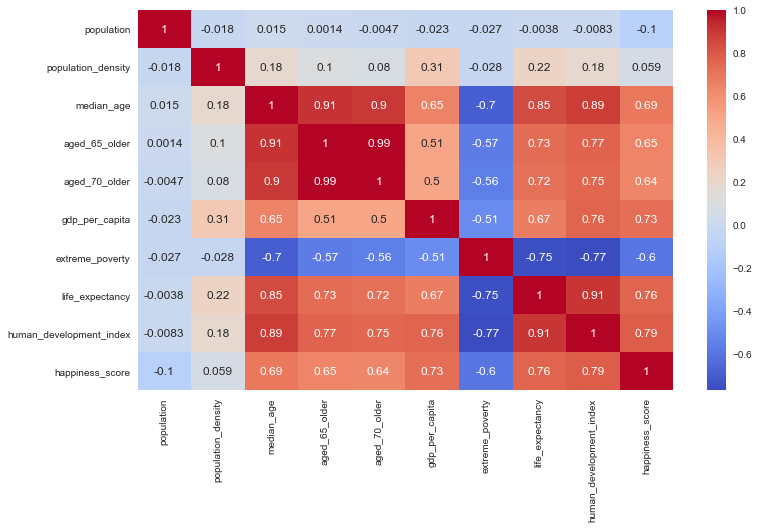

In [14]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(),annot=True, cmap="coolwarm");

In [15]:
df.columns

Index(['population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'life_expectancy',
       'human_development_index', 'happiness_score'],
      dtype='object')

In [16]:
df= df[['median_age', 
#              'population', # belirleyici sutun degil
#              'population_density', #  # belirleyici sutun degil
             'aged_65_older',
#              'aged_70_older', # aged_65_older ile benzer
             'gdp_per_capita', 
             'extreme_poverty', 
             'life_expectancy',
             'human_development_index', 
             'happiness_score']]
df.sample(10)

median_age  aged_65_older  gdp_per_capita  extreme_poverty  \
location                                                                   
Libya               29.0          4.424       17881.509              NaN   
Barbados            39.8         14.952       16978.068              NaN   
Bangladesh          27.5          5.098        3523.984             14.8   
Burkina Faso        17.6          2.409        1703.102             43.7   
Gabon               23.1          4.450       16562.413              3.4   
Samoa               22.0          5.606        6021.557              NaN   
Algeria             29.1          6.211       13913.839              0.5   
Tanzania            17.7          3.108        2683.304             49.1   
Congo               19.0          3.402        4881.406             37.0   
Chad                16.7          2.486        1768.153             38.4   

              life_expectancy  human_development_index  happiness_score  
location                                                                 
Libya                   72.91                    0.706            5.489  
Barbados                79.19                    0.800              NaN  
Bangladesh              72.59                    0.608            4.833  
Burkina Faso            61.58                    0.423            4.769  
Gabon                   66.47                    0.702            4.829  
Samoa                   73.32                    0.713              NaN  
Algeria                 76.88                    0.754            5.005  
Tanzania                65.46                    0.538            3.476  
Congo                   64.57                    0.606            4.311  
Chad                    54.24                    0.404            4.423

In [17]:
df.dropna(how='all',inplace=True) # drop all rows with all columns Nan

In [18]:
null_values(df)

Missing_Records  Percentage (%)
extreme_poverty                       66       34.736842
happiness_score                       41       21.578947
aged_65_older                         11        5.789474
median_age                             9        4.736842
gdp_per_capita                         8        4.210526
human_development_index                7        3.684211
life_expectancy                        1        0.526316

In [19]:
df.loc["World"]

median_age                    30.900
aged_65_older                  8.696
gdp_per_capita             15469.207
extreme_poverty               10.000
life_expectancy               72.580
human_development_index          NaN
happiness_score                  NaN
Name: World, dtype: float64

> **Let's focus the columns with nan values separately**

### extreme_poverty
* Lets fill in NAN values according to the column with the highest correlation with this column.

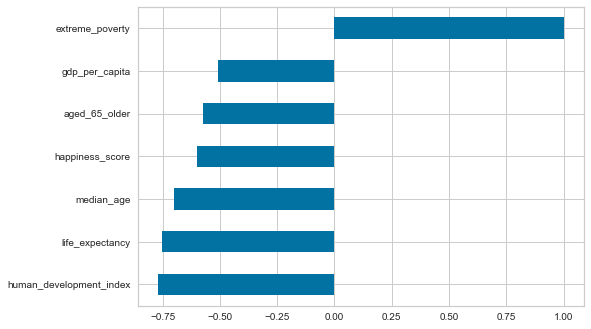

In [20]:
df.corr()["extreme_poverty"].sort_values().plot.barh();

In [21]:
def k_score(df, col_name):
    from yellowbrick.cluster import KElbowVisualizer
    from sklearn.cluster import KMeans
    
    df_new=df.copy()
    df_new[df_new[col_name].isnull()]=1000000
    df_new = df_new[col_name].values.reshape(-1, 1)
    kmeans = KMeans()
    visu = KElbowVisualizer(kmeans, k=(2, 10))
    visu.fit(df_new)
    visu.poof()

In [22]:
def fill(df, group_col, col_name, num_of_clusters):
    from sklearn.cluster import KMeans
    
    df_new=df.copy()
    df_new[df_new[group_col].isnull()]=1000000
    df_new = df_new[group_col].values.reshape(-1, 1)
    kmeans_model = KMeans(n_clusters= num_of_clusters).fit(df_new)
    df_new_pred = kmeans_model.predict(df_new)
    df[group_col+'_clusters'] = df_new_pred
    df[col_name] = df.groupby(group_col+'_clusters')[col_name].apply(lambda x: x.fillna(x.mean()))
    print(f'Number of NaN : {df[col_name].isnull().sum()} in "{col_name}" column.\n------------------')
    return df[df.extreme_poverty.isnull()]
    

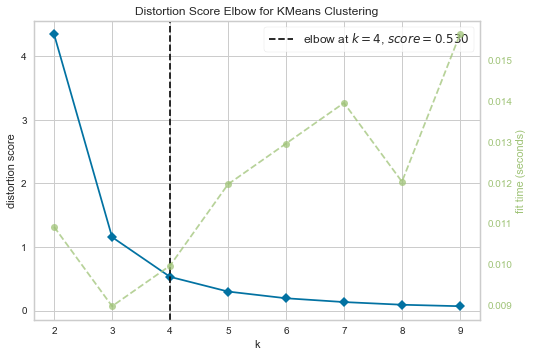

In [23]:
k_score(df,'human_development_index')

In [24]:
fill(df,'human_development_index','extreme_poverty',4)

Number of NaN : 0 in "extreme_poverty" column.
------------------


Empty DataFrame
Columns: [median_age, aged_65_older, gdp_per_capita, extreme_poverty, life_expectancy, human_development_index, happiness_score, human_development_index_clusters]
Index: []

In [25]:
# df.dropna(subset=['extreme_poverty'],inplace=True)

In [26]:
null_values(df)

Missing_Records  Percentage (%)
happiness_score                       41       21.578947
aged_65_older                         11        5.789474
median_age                             9        4.736842
gdp_per_capita                         8        4.210526
human_development_index                7        3.684211
life_expectancy                        1        0.526316

### happiness_score	

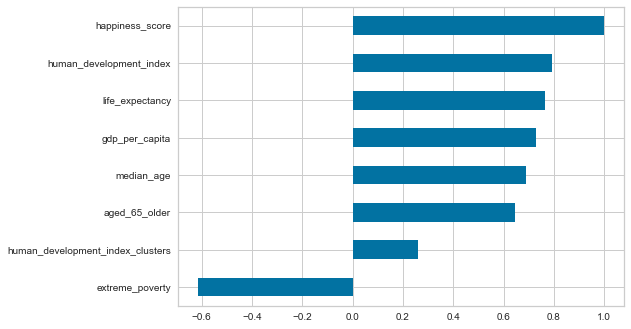

In [27]:
df.corr()["happiness_score"].sort_values().plot.barh();

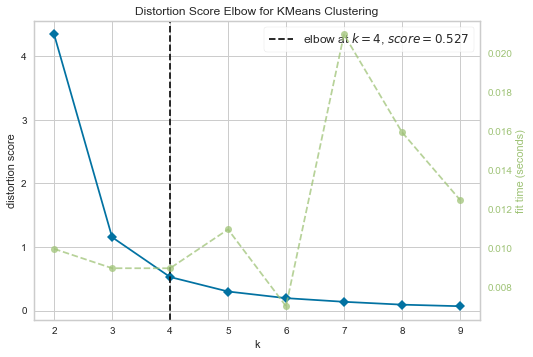

In [28]:
k_score(df,'human_development_index')

In [29]:
fill(df,'human_development_index','happiness_score',4)

Number of NaN : 0 in "happiness_score" column.
------------------


Empty DataFrame
Columns: [median_age, aged_65_older, gdp_per_capita, extreme_poverty, life_expectancy, human_development_index, happiness_score, human_development_index_clusters]
Index: []

In [30]:
null_values(df)

Missing_Records  Percentage (%)
aged_65_older                         11        5.789474
median_age                             9        4.736842
gdp_per_capita                         8        4.210526
human_development_index                7        3.684211
life_expectancy                        1        0.526316

### aged_65_older

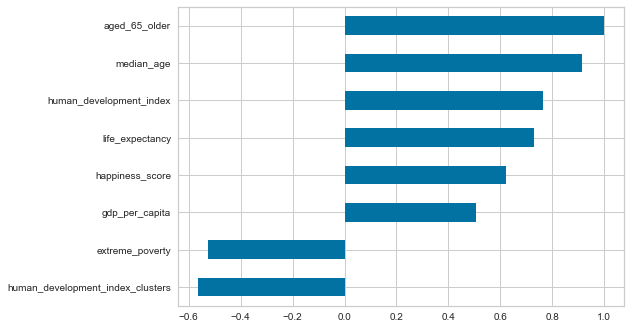

In [31]:
df.corr()["aged_65_older"].sort_values().plot.barh();

In [32]:
df[df.aged_65_older.isnull()][['median_age','aged_65_older']]

median_age  aged_65_older
location                                        
Andorra                       NaN            NaN
Dominica                      NaN            NaN
Kosovo                        NaN            NaN
Liechtenstein                 NaN            NaN
Marshall Islands              NaN            NaN
Monaco                        NaN            NaN
Saint Kitts and Nevis         NaN            NaN
San Marino                    NaN            NaN
Syria                        21.7            NaN
Taiwan                       42.2            NaN
Vatican                       NaN            NaN

> 'aged_65_older' in Nan oldugu yerde "median_age" de Nan oldugundan, filling i 'median_age' e gore yapamayiz

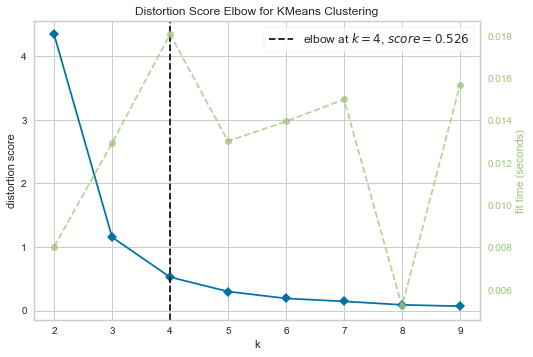

In [33]:
k_score(df,'human_development_index')

In [34]:
fill(df,'human_development_index','aged_65_older',4)

Number of NaN : 0 in "aged_65_older" column.
------------------


Empty DataFrame
Columns: [median_age, aged_65_older, gdp_per_capita, extreme_poverty, life_expectancy, human_development_index, happiness_score, human_development_index_clusters]
Index: []

In [35]:
null_values(df)

Missing_Records  Percentage (%)
median_age                             9        4.736842
gdp_per_capita                         8        4.210526
human_development_index                7        3.684211
life_expectancy                        1        0.526316

### median_age

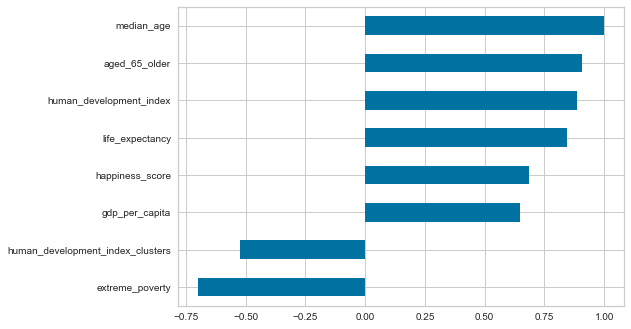

In [36]:
df.corr()["median_age"].sort_values().plot.barh();

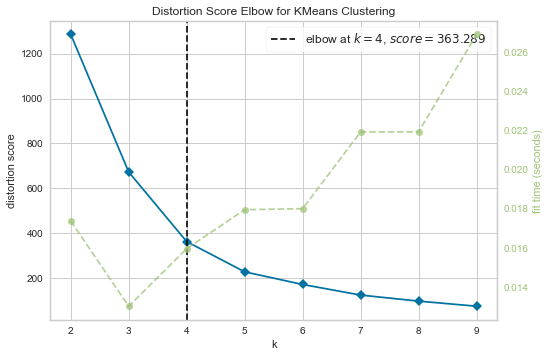

In [37]:
k_score(df,'aged_65_older')

In [38]:
fill(df,'aged_65_older','median_age',4)

Number of NaN : 0 in "median_age" column.
------------------


Empty DataFrame
Columns: [median_age, aged_65_older, gdp_per_capita, extreme_poverty, life_expectancy, human_development_index, happiness_score, human_development_index_clusters, aged_65_older_clusters]
Index: []

In [39]:
null_values(df)

Missing_Records  Percentage (%)
gdp_per_capita                         8        4.210526
human_development_index                7        3.684211
life_expectancy                        1        0.526316

### gdp_per_capita

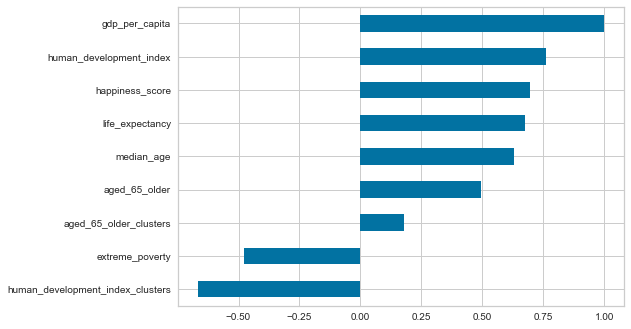

In [40]:
df.corr()["gdp_per_capita"].sort_values().plot.barh();

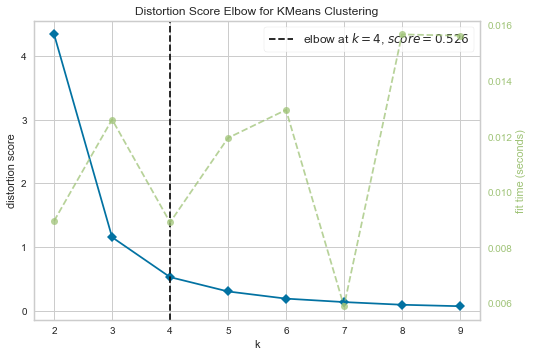

In [41]:
k_score(df,'human_development_index')

In [42]:
fill(df,'human_development_index','gdp_per_capita',4)

Number of NaN : 0 in "gdp_per_capita" column.
------------------


Empty DataFrame
Columns: [median_age, aged_65_older, gdp_per_capita, extreme_poverty, life_expectancy, human_development_index, happiness_score, human_development_index_clusters, aged_65_older_clusters]
Index: []

In [43]:
null_values(df)

Missing_Records  Percentage (%)
human_development_index                7        3.684211
life_expectancy                        1        0.526316

### human_development_index

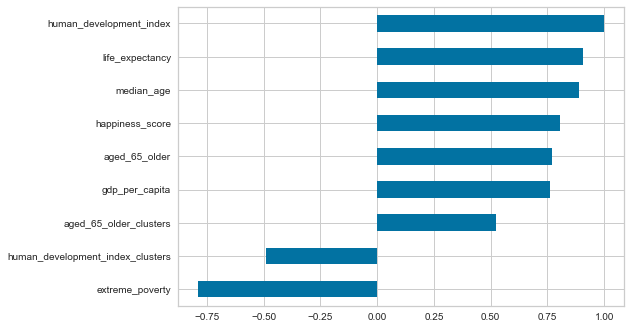

In [44]:
df.corr()["human_development_index"].sort_values().plot.barh();

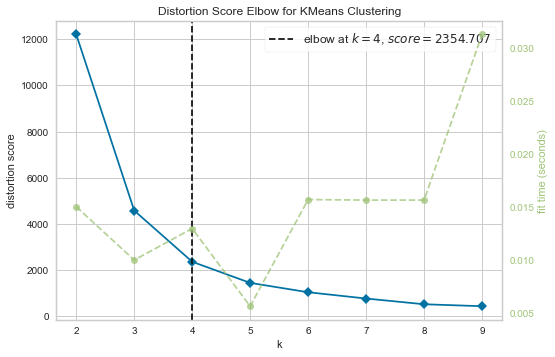

In [45]:
k_score(df,'extreme_poverty')

In [46]:
fill(df,'extreme_poverty','human_development_index',4)

Number of NaN : 0 in "human_development_index" column.
------------------


Empty DataFrame
Columns: [median_age, aged_65_older, gdp_per_capita, extreme_poverty, life_expectancy, human_development_index, happiness_score, human_development_index_clusters, aged_65_older_clusters, extreme_poverty_clusters]
Index: []

In [47]:
null_values(df)

Missing_Records  Percentage (%)
life_expectancy                1        0.526316

### life_expectancy

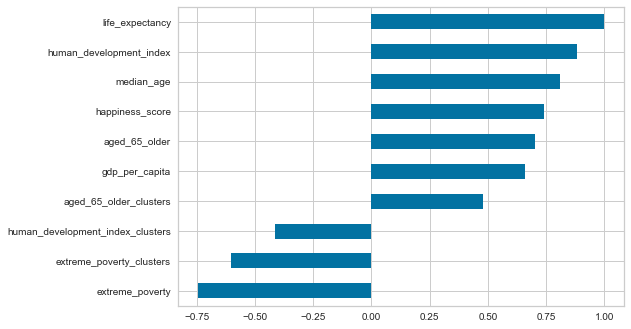

In [48]:
df.corr()["life_expectancy"].sort_values().plot.barh();

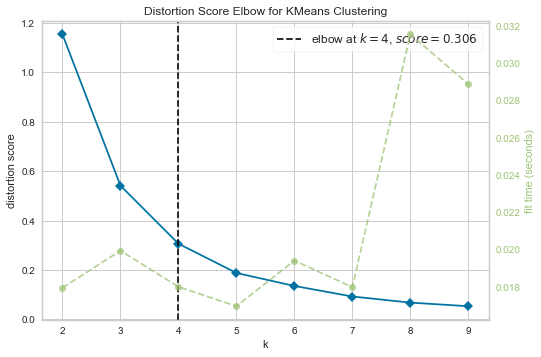

In [49]:
k_score(df,'human_development_index')

In [50]:
fill(df,'human_development_index','life_expectancy',4)

Number of NaN : 0 in "life_expectancy" column.
------------------


Empty DataFrame
Columns: [median_age, aged_65_older, gdp_per_capita, extreme_poverty, life_expectancy, human_development_index, happiness_score, human_development_index_clusters, aged_65_older_clusters, extreme_poverty_clusters]
Index: []

In [51]:
null_values(df)

Empty DataFrame
Columns: [Missing_Records, Percentage (%)]
Index: []

### Drop useless columns

In [52]:
df.columns

Index(['median_age', 'aged_65_older', 'gdp_per_capita', 'extreme_poverty',
       'life_expectancy', 'human_development_index', 'happiness_score',
       'human_development_index_clusters', 'aged_65_older_clusters',
       'extreme_poverty_clusters'],
      dtype='object')

In [53]:
df.drop(['human_development_index_clusters', 
         'aged_65_older_clusters', 
         'extreme_poverty_clusters'],axis=1,inplace=True)

In [54]:
df.isnull().sum()

median_age                 0
aged_65_older              0
gdp_per_capita             0
extreme_poverty            0
life_expectancy            0
human_development_index    0
happiness_score            0
dtype: int64

## Modelling
### Hopkins Score
* Zaman ve maliyet verimliliği için, İlk olarak Veride kümeleme eğilimi var mi yok mu belirlemek için ``Hopkins Testi`` yapılır.
* Null Hypothesis(Ho) ve Alternative Hypothesis(Ha) temeline dayaniyor.
* Null Hypothesis(Ho): Uniform dagilim var, anlamli kümeleme yok.
* Alternative Hypothesis(Ha):  Veri, ratsgele veri noktalarindan oluşur. Yani Kumeleme vardir.
* [0,1] araliginda bir score verir. score, 0’a yaklaştıkça veri uniform degil,yani clusteringe meyilli
* 1’e yaklaştıkça uniform yapi var, 0.5 gecmedikce kümelenebilir olarak ifade edilir. pratikte 0.3 sinir alinir.

In [55]:
df.head()

median_age  aged_65_older  gdp_per_capita  extreme_poverty  \
location                                                                  
Afghanistan       18.60       2.581000     1803.987000        35.165909   
Albania           38.00      13.188000    11803.431000         1.100000   
Algeria           29.10       6.211000    13913.839000         0.500000   
Andorra           39.75      15.078304    41675.253868         0.607407   
Angola            16.80       2.405000     5819.495000        35.165909   

             life_expectancy  human_development_index  happiness_score  
location                                                                
Afghanistan            64.83                    0.498         2.567000  
Albania                78.57                    0.785         4.883000  
Algeria                76.88                    0.754         5.005000  
Andorra                83.73                    0.858         6.453185  
Angola                 61.15                    0.581         4.320286

In [56]:
from pyclustertend import hopkins
from sklearn.preprocessing import scale

In [57]:
hopkins(df,df.shape[0])

0.19926674642125275

In [58]:
hopkins(scale(df),df.shape[0]) #standart scaler alternatifidir.

0.14851488266751373

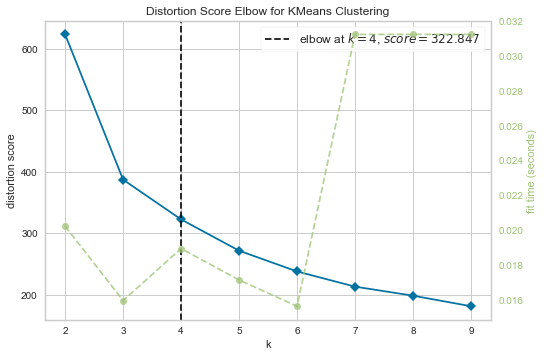

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [59]:
kmeans = KMeans()

visu = KElbowVisualizer(kmeans, k=(2, 10))
visu.fit(scale(df))
visu.poof()

### Scaling

In [60]:
df_scaled=scale(df)

### K-Means

In [61]:
kmeans_model = KMeans(n_clusters=3, random_state=42).fit(df_scaled)

In [62]:
labels=kmeans_model.labels_
labels

# alternative
# df_pred = kmeans_model.predict(df)
# df_pred

array([0, 2, 2, 1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 0, 2, 2, 1,
       2, 2, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 2, 0, 0, 2, 0, 1, 1, 1,
       0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 1, 0, 0, 2, 1, 1, 2, 0, 2, 1, 0, 1,
       2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 0,
       2, 2, 2, 0, 1, 2, 0, 0, 2, 1, 1, 1, 0, 0, 2, 2, 0, 1, 2, 0, 2, 2,
       2, 2, 2, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 2, 1, 2, 2, 2, 2, 0, 2,
       2, 2, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 0, 1, 1, 1,
       0, 2, 2, 1, 0, 1, 2, 0, 2, 1, 1, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0,
       2, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 0, 0, 0])

In [63]:
np.unique(labels, return_counts=True)

(array([0, 1, 2]), array([53, 53, 84], dtype=int64))

In [64]:
from sklearn.metrics import silhouette_score
silhouette_score(df_scaled, labels)

0.4152955338712718

In [65]:
df['Kmeans_clusters'] = labels
df.sample(5)

median_age  aged_65_older  gdp_per_capita  \
location                                                            
Bosnia and Herzegovina        42.5         16.569       11713.895   
Tunisia                       32.7          8.001       10849.297   
Italy                         47.9         23.021       35220.084   
Barbados                      39.8         14.952       16978.068   
Belize                        25.0          3.853        7824.362   

                        extreme_poverty  life_expectancy  \
location                                                   
Bosnia and Herzegovina         0.200000            77.40   
Tunisia                        2.000000            76.70   
Italy                          2.000000            83.51   
Barbados                       2.966667            79.19   
Belize                         2.966667            74.62   

                        human_development_index  happiness_score  \
location                                                           
Bosnia and Herzegovina                    0.768         5.674000   
Tunisia                                   0.735         4.392000   
Italy                                     0.880         6.387000   
Barbados                                  0.800         6.453185   
Belize                                    0.708         5.346216   

                        Kmeans_clusters  
location                                 
Bosnia and Herzegovina                1  
Tunisia                               2  
Italy                                 1  
Barbados                              1  
Belize                                2

## Hierarchy Clustering

In [66]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [67]:
linked = linkage(df_scaled, "ward")

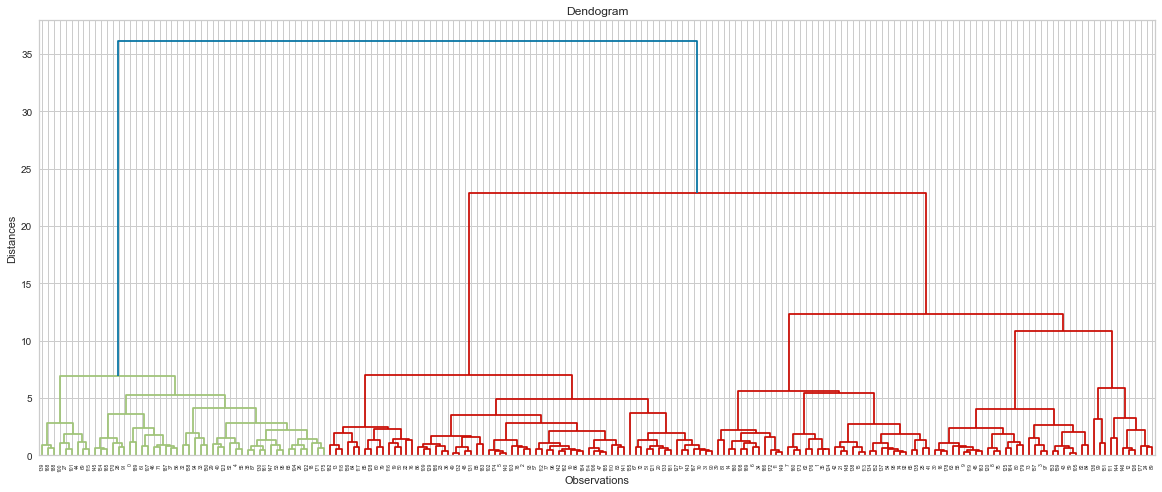

In [68]:
plt.figure(figsize = (20,8))
plt.title("Dendogram")
plt.xlabel("Observations")
plt.ylabel("Distances")
dendrogram(linked);

In [69]:
hc = AgglomerativeClustering (n_clusters = 3)
hc.fit_predict(df_scaled)

array([1, 0, 2, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 2, 2, 0,
       2, 2, 0, 0, 1, 1, 1, 1, 0, 2, 1, 1, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 2, 0, 0, 2, 1, 0, 0, 2, 0,
       2, 2, 1, 1, 2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 1,
       2, 0, 2, 1, 0, 2, 1, 1, 2, 0, 0, 0, 1, 1, 2, 2, 1, 0, 2, 1, 0, 2,
       2, 0, 2, 0, 2, 1, 2, 2, 2, 0, 0, 2, 1, 1, 0, 0, 0, 2, 2, 2, 1, 2,
       2, 2, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 2, 2, 0, 1, 0, 0, 1, 2, 0, 0, 1, 0, 2, 1, 0, 1, 1, 0, 0, 2, 1,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1], dtype=int64)

In [70]:
labels = hc.labels_

In [71]:
np.unique(labels, return_counts=True)

(array([0, 1, 2], dtype=int64), array([75, 49, 66], dtype=int64))

In [72]:
silhouette_score(df_scaled, labels)

0.36832390742977483

In [73]:
df["Hc_clusters"]=labels
df.sample(5)

median_age  aged_65_older  gdp_per_capita  \
location                                                              
Fiji                            28.6          6.224        8702.975   
World                           30.9          8.696       15469.207   
Italy                           47.9         23.021       35220.084   
Bhutan                          28.6          4.885        8708.597   
Central African Republic        18.3          3.655         661.240   

                          extreme_poverty  life_expectancy  \
location                                                     
Fiji                             1.400000            67.44   
World                           10.000000            72.58   
Italy                            2.000000            83.51   
Bhutan                           1.500000            71.78   
Central African Republic        35.165909            53.28   

                          human_development_index  happiness_score  \
location                                                             
Fiji                                     0.741000         5.346216   
World                                    0.790391         6.390000   
Italy                                    0.880000         6.387000   
Bhutan                                   0.612000         4.320286   
Central African Republic                 0.367000         3.476000   

                          Kmeans_clusters  Hc_clusters  
location                                                
Fiji                                    2            2  
World                                   2            2  
Italy                                   1            0  
Bhutan                                  2            2  
Central African Republic                0            1

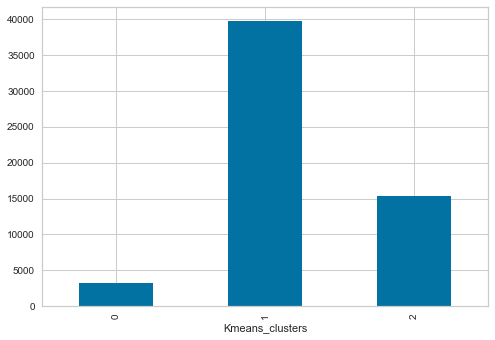

In [74]:
df.groupby('Kmeans_clusters').gdp_per_capita.mean().plot(kind='bar');

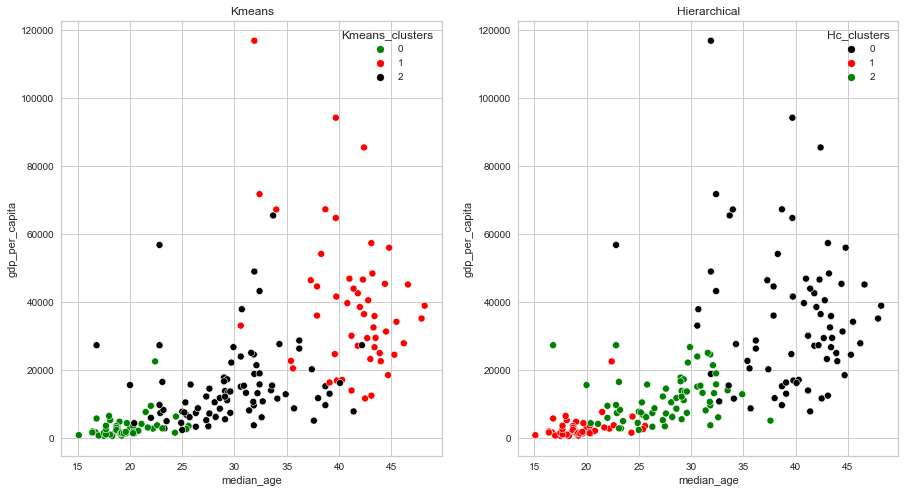

In [75]:
plt.figure(figsize=(15,8))

plt.subplot(121)
plt.title("Kmeans")
plt.xlabel('median_age')
plt.ylabel('gdp_per_capita')
sns.scatterplot(x='median_age', y='gdp_per_capita' ,data=df, hue='Kmeans_clusters',palette=['green','red','black'])

plt.subplot(122)
plt.title("Hierarchical")
plt.xlabel('median_age')
sns.scatterplot(x='median_age', y='gdp_per_capita' ,data=df, hue='Hc_clusters',palette=['black','red','green'])
plt.show()

In [76]:
# Alternative
# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))
# ax1.set_title('Kmeans')
# ax1.set_xlabel("median_age")
# ax1.set_ylabel("gdp_per_capita")
# ax1.scatter(df.iloc[:,0], df.iloc[:,2], c = df["Kmeans_clusters"], s = 50, cmap = "rainbow")
# ax2.set_title("Hierarchical")
# ax2.set_xlabel("median_age")
# # ax2.set_ylabel("gdp_per_capita")
# ax2.scatter(df.iloc[:,0], df.iloc[:,2], c = df["Hc_clusters"], s = 50, cmap = "rainbow")
# plt.show

In [77]:
# df.to_csv("countries_final.csv")

### Visualization of Clusters in Maps

In [78]:
df=df.reset_index().rename(columns={'index':'location'})

In [80]:
list_countries=df.location

import pycountry
d_country_code = {}  # To hold the country names and their ISO
for country in list_countries:
    try:
        country_data = pycountry.countries.search_fuzzy(country)
        # country_data is a list of objects of class pycountry.db.Country
        # The first item  ie at index 0 of list is best fit
        # object of class Country have an alpha_3 attribute
        country_code = country_data[0].alpha_3
        d_country_code.update({country: country_code})
    except:
        print('could not add ISO 3 code for ->', country)
        # If could not find country, make ISO code ' '
        d_country_code.update({country: ' '})

could not add ISO 3 code for -> Cape Verde
could not add ISO 3 code for -> Democratic Republic of Congo
could not add ISO 3 code for -> Laos
could not add ISO 3 code for -> South Korea
could not add ISO 3 code for -> World


In [81]:
df['countries_abbrev']=df['location'].replace(d_country_code)
df.head()

location  median_age  aged_65_older  gdp_per_capita  extreme_poverty  \
0  Afghanistan       18.60       2.581000     1803.987000        35.165909   
1      Albania       38.00      13.188000    11803.431000         1.100000   
2      Algeria       29.10       6.211000    13913.839000         0.500000   
3      Andorra       39.75      15.078304    41675.253868         0.607407   
4       Angola       16.80       2.405000     5819.495000        35.165909   

   life_expectancy  human_development_index  happiness_score  Kmeans_clusters  \
0            64.83                    0.498         2.567000                0   
1            78.57                    0.785         4.883000                2   
2            76.88                    0.754         5.005000                2   
3            83.73                    0.858         6.453185                1   
4            61.15                    0.581         4.320286                0   

   Hc_clusters countries_abbrev  
0            1              AFG  
1            0              ALB  
2            2              DZA  
3            0              AND  
4            1              AGO

In [82]:
df['Kmeans_clusters']=df['Kmeans_clusters'].astype('str')
df['Hc_clusters']=df['Hc_clusters'].astype('str')

In [83]:
import plotly.express as px

fig = px.choropleth(data_frame = df,
                    locations= "countries_abbrev",
                    color= "Kmeans_clusters",  # value in column 'Confirmed' determines color
                    hover_name= "location",
                    color_continuous_scale= 'RdYlGn')

fig.show()

In [84]:
import plotly.express as px

fig = px.choropleth(data_frame = df,
                    locations= "countries_abbrev",
                    color= "Hc_clusters",  # value in column 'Confirmed' determines color
                    hover_name= "location",
                    color_continuous_scale= 'RdYlGn')

fig.show()